In [1]:
# CNN for breast cancer dataset
'''
/Dataset/
    /benign/
        [random].png
    /malignant/
        ...
    /normal/
        ...
'''

import os

In [2]:
# import all the necessary libraries
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

import torch
import torchvision
from torchvision import models
from torch.utils.data import DataLoader
from torchvision import transforms as T
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

In [3]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [4]:
get_default_device()

device(type='cuda')

In [5]:
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [6]:
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [7]:
def eval_accuracy(loader, model_name): 
    """
    Gives out accuracy for a model
    """
    model = model_name
    model.eval()
    corrects = 0
    total = 0
    for images, labels in loader:
        images, labels = to_device(images, device), to_device(labels, device)
        predictions = model(images)
        predict = to_device(torch.max(predictions.data, 1)[1], device)
        total += len(labels)
        corrects += (predict == labels).sum()
    accuracy = 100 * corrects / float(total)
    return accuracy


In [8]:
def plot_loss_curves(history):
    """
    Plots the curves for both loss and accuracy.
    """
    train_loss = [item['train_loss'] for item in history[1:]]
    val_loss = [item['val_loss'] for item in history[1:]]

    train_accuracy = [item['train_acc'] for item in history[1:]]
    val_accuracy = [item['val_acc'] for item in history[1:]]

    epochs = range(len(train_loss))

    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    ax1 = sns.lineplot(x=epochs, y=train_loss, label='Training Loss', ax=ax[0])
    ax1 = sns.lineplot(x=epochs, y=val_loss, label='Validation Loss', ax=ax[0])
    ax1.set_title('Losses')
    ax2 = sns.lineplot(x=epochs, y=train_accuracy, label='Training Accuracy', ax=ax[1])
    ax2 = sns.lineplot(x=epochs, y=val_accuracy, label='Validation Accuracy', ax=ax[1])
    ax2.set_title('Accuracies')


In [9]:
def predict_image_from_test(model, index=None):
    """
    Outputs a random image from the test data (if the index is not given), 
    with the index no., original label and the predicted label
    """
    if index is None:
        index = np.random.randint(len(test_ds_1)-1)
    img, label = test_ds_1[index]
    x = to_device(img.unsqueeze(0), device)
    y = model(x)
    _, preds  = torch.max(y, dim=1)
    print('Index no.:', index, ', Label:', classes[label], ', Predicted:', classes[preds[0].item()])
    plt.imshow(img.permute(1, 2, 0))
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [10]:
device = get_default_device()

In [11]:
BATCH_SIZE = 2
epochs = 50
L_rate = 0.01
gradient_clip = 0.1
weight_decay = 0.0001
opti = torch.optim.Adam

In [12]:
root_dir = "./archive/Dataset_BUSI_with_GT"

In [13]:
path = Path(root_dir)
path_img = list(path.glob('**/*.png'))

In [14]:
path_img

[WindowsPath('archive/Dataset_BUSI_with_GT/benign/benign (1).png'),
 WindowsPath('archive/Dataset_BUSI_with_GT/benign/benign (1)_mask.png'),
 WindowsPath('archive/Dataset_BUSI_with_GT/benign/benign (10).png'),
 WindowsPath('archive/Dataset_BUSI_with_GT/benign/benign (10)_mask.png'),
 WindowsPath('archive/Dataset_BUSI_with_GT/benign/benign (100).png'),
 WindowsPath('archive/Dataset_BUSI_with_GT/benign/benign (100)_mask.png'),
 WindowsPath('archive/Dataset_BUSI_with_GT/benign/benign (100)_mask_1.png'),
 WindowsPath('archive/Dataset_BUSI_with_GT/benign/benign (101).png'),
 WindowsPath('archive/Dataset_BUSI_with_GT/benign/benign (101)_mask.png'),
 WindowsPath('archive/Dataset_BUSI_with_GT/benign/benign (102).png'),
 WindowsPath('archive/Dataset_BUSI_with_GT/benign/benign (102)_mask.png'),
 WindowsPath('archive/Dataset_BUSI_with_GT/benign/benign (103).png'),
 WindowsPath('archive/Dataset_BUSI_with_GT/benign/benign (103)_mask.png'),
 WindowsPath('archive/Dataset_BUSI_with_GT/benign/benign (1

In [15]:
images_paths = [str(path_image) for path_image in path_img if '_mask' not in str(path_image)]
print(f'Number of training images: {len(images_paths)}')

labels = [os.path.split(os.path.split(name)[0])[1] for name in images_paths]
print(f'Number of labels: {len(labels)}')

Number of training images: 780
Number of labels: 780


In [16]:
classes = list(set(labels))
labels_dict = {label : i for i,label in enumerate(classes)}
labels_val = [labels_dict[label_key] for label_key in labels]

In [17]:
print("No. of classes: ", len(classes))
print("Various Classes: ", classes)
img = Image.open(images_paths[18])
print("Random image size: ", img.size)


No. of classes:  3
Various Classes:  ['normal', 'benign', 'malignant']
Random image size:  (554, 469)


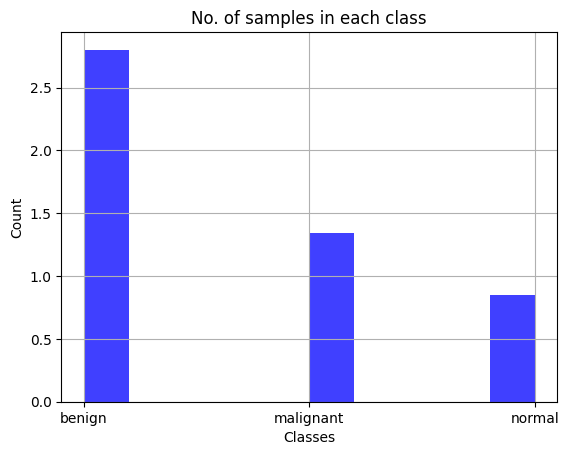

In [18]:
no_of_samples = pd.DataFrame(labels, columns=["class"])
plt.hist(no_of_samples, density=True, facecolor='b', alpha=0.75)
plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('No. of samples in each class')
plt.grid(True)
plt.show()

Randomly sampled images from the data: 


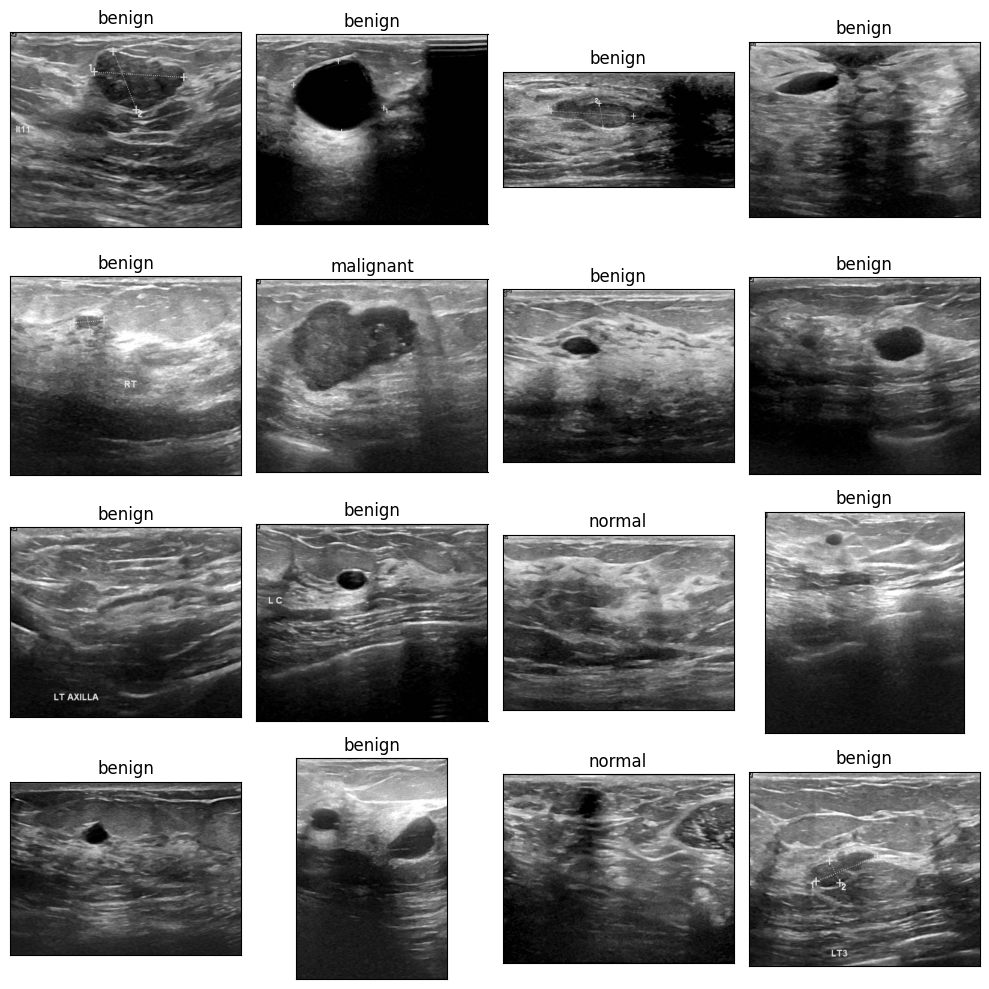

In [19]:
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(images_paths), 16)
fig, axes = plt.subplots(4,4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

print('Randomly sampled images from the data: ')

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(images_paths[random_index[i]]))
    ax.set_title(labels[random_index[i]])
plt.tight_layout()
plt.show()

In [20]:
data, test_data, labels, test_labels = train_test_split(images_paths, labels_val, test_size=0.15, shuffle=True)
train_data, val_data, train_labels, val_labels = train_test_split(data, labels, test_size=0.1, shuffle=True)

In [21]:
# a class to create data sets
class Dataset(torch.utils.data.Dataset):
    def __init__(self, images: list, labels: list, transform=None):
        super().__init__()
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self, ):
        return len(self.labels)

    def __getitem__(self, index):
        image = Image.open(self.images[index])

        image = self.transform(image)
            
        label = self.labels[index]

        return image, label

In [22]:
# simple transformations
basic = T.Compose([
    T.Resize([324,324]),
    T.ToTensor()
    ])

In [23]:
#creating datasets with basically no augmentations
train_ds_1 = Dataset(images=train_data,labels=train_labels, transform=basic)
val_ds_1 = Dataset(images=val_data,labels=val_labels, transform=basic)
test_ds_1 = Dataset(images=test_data,labels=test_labels, transform=basic)

In [24]:
train_loader_1 = DataLoader(train_ds_1, batch_size=BATCH_SIZE, num_workers=0, pin_memory=True, shuffle=True)
val_loader_1 = DataLoader(val_ds_1, batch_size=BATCH_SIZE, num_workers=0, pin_memory=True)
test_loader_1 = DataLoader(test_ds_1, batch_size=BATCH_SIZE, num_workers=0, pin_memory=True, shuffle=True) 

In [25]:
# sending data to the device i.e. CPU or a GPU whatever is available
train_dl_1 = DeviceDataLoader(train_loader_1, device)
valid_dl_1 = DeviceDataLoader(val_loader_1, device)

In [26]:
class TestModel(nn.Module):

    def __init__(self):
        super(TestModel, self).__init__()
        # 3 input image channels, 6 output channels, 5x5 square convolution kernel
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 24, 3)
        
        self.fc1 = nn.Linear(24 * 79 * 79, 2048)  
        self.fc2 = nn.Linear(2048, 256)
        self.fc3 = nn.Linear(256, 64)
        self.fc4 = nn.Linear(64, 3)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)

        # changing the shape to pass to the next flattened layer
        x = x.view(x.size(0), 24 * 79 * 79)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

print(TestModel())

TestModel(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 24, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=149784, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=3, bias=True)
)


In [27]:
@torch.no_grad()
def accuracy(outputs, labels):
    """
    Function to calculate the accuracy.
    """
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds==labels).item()/preds.size(0))


def evaluate(model, val_loader):
    """
    Function to evaluate the model and output scores such as validation loss and accuracy.
    """
    model.eval()
    
    val_losses, val_accuracy = [], []
    target_count, correct_val = 0, 0
    
    for images, labels in val_loader:
        target = labels.cuda()
        input_var = Variable(images, volatile=True)
        target_var = Variable(labels, volatile=True)
        
        out = model(images)                        #generate predictions
        val_loss = F.cross_entropy(out, labels)    #calculate loss
        
        _, predicted = torch.max(out.data, 1)      #calculate accuracy
        target_count += target_var.size(0)
        correct_val += (target_var==predicted).sum().item()
        val_acc = (100 * correct_val)/target_count 
        
        #record the loss and training accuracy
        val_losses.append(val_loss)
        val_accuracy.append(val_acc)
        
    val_loss = torch.stack(val_losses).mean().item()
    val_acc = sum(val_accuracy)/len(val_accuracy)

    return {'val_loss': val_loss, 'val_acc': val_acc}


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

    
def fit_one_cycle(model, train_loader, val_loader, epochs=epochs, max_lr=0.01, weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD, patience=3):
    """
    Function to run the training loop with multiple hyperparameters.
    """
    torch.cuda.empty_cache()
    history = []
    
    #early stopping
    last_loss = 100
    triggertimes = 0
    
    #extras
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        #training loop
        model.train()
        
        train_accuracy = []
        train_losses = []
        lrs = []
        target_count = 0
        correct_train = 0
        
        for images, labels in tqdm(train_loader):
            target = labels.cuda()
            input_var = Variable(images)
            target_var = Variable(labels)
            
            #generating predictions on image
            out = model(images)    
            
            #calculating loss
            loss = F.cross_entropy(out, labels)
            
            # accuracy
            _, predicted = torch.max(out.data, 1)
            target_count += target_var.size(0)
            correct_train += (target_var==predicted).sum().item()
            train_acc = (100 * correct_train)/target_count
            
            #record the loss and training accuracy
            train_losses.append(loss)
            train_accuracy.append(train_acc)
            
            #pass back the gradients calculated to the entire network
            loss.backward() 

            #for gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            #does the weight update
            optimizer.step() 
            
            #zero the gradient buffers else gradients will be accumulated to existing gradients
            optimizer.zero_grad() 

            #record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        #model validation
        result = evaluate(model, val_loader)
        result['train_acc'] = sum(train_accuracy)/len(train_accuracy)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        
        #training loop output
        print(":::Epoch[{}]::: {} Training Acc.: {:.3f} %, Training Loss: {:.5f}".format(
            epoch, "Last LR: {:.5f},".format(result['lrs'][-1]) if 'lrs' in result else '', 
            result['train_acc'], result['train_loss']))
        
        #early stopping [Sourced from: https://pythonguides.com/pytorch-early-stopping/]
        current_loss = result['val_loss']
        print(':::::::::::::: Current Validation Acc.: {:.3f} %\n:::::::::::::: Current Validation Loss: {:.5f}'.format(result['val_acc'], current_loss))

        if current_loss > last_loss:
            trigger_times += 1
            print('Patience triggered:', trigger_times)

            if trigger_times >= patience:
                print('Early stopping activated!\nYour model has finished training!')
                history.append(result)
                break

        else:
            print('Model is improving...')
            trigger_times = 0
            
        last_loss = current_loss
        
        #finally appending the result
        history.append(result)
        
    print('Your model has finished training!')
    return history

In [28]:
# initializing the model and sending it to the device
model_1 = TestModel()
to_device(model_1, device)

TestModel(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 24, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=149784, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=3, bias=True)
)

In [29]:
# running a test run 
history = [evaluate(model_1, valid_dl_1)]
history

[{'val_loss': 1.1255370378494263, 'val_acc': 20.54909064312648}]

In [30]:
torch.cuda.is_available()

True

In [31]:

history += fit_one_cycle(model_1, train_dl_1, valid_dl_1, epochs=epochs, max_lr=L_rate, weight_decay=weight_decay, grad_clip=None, opt_func=opti)

  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[0]::: Last LR: 0.00050, Training Acc.: 49.286 %, Training Loss: 1.01775
:::::::::::::: Current Validation Acc.: 63.214 %
:::::::::::::: Current Validation Loss: 0.95648
Model is improving...


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[1]::: Last LR: 0.00081, Training Acc.: 58.652 %, Training Loss: 0.98896
:::::::::::::: Current Validation Acc.: 63.214 %
:::::::::::::: Current Validation Loss: 1.03908
Patience triggered: 1


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[2]::: Last LR: 0.00132, Training Acc.: 56.703 %, Training Loss: 0.98958
:::::::::::::: Current Validation Acc.: 63.712 %
:::::::::::::: Current Validation Loss: 0.93308
Model is improving...


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[3]::: Last LR: 0.00199, Training Acc.: 56.192 %, Training Loss: 1.00433
:::::::::::::: Current Validation Acc.: 59.856 %
:::::::::::::: Current Validation Loss: 1.04430
Patience triggered: 1


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[4]::: Last LR: 0.00280, Training Acc.: 55.945 %, Training Loss: 1.03993
:::::::::::::: Current Validation Acc.: 63.214 %
:::::::::::::: Current Validation Loss: 0.99094
Model is improving...


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[5]::: Last LR: 0.00371, Training Acc.: 56.019 %, Training Loss: 1.07427
:::::::::::::: Current Validation Acc.: 63.214 %
:::::::::::::: Current Validation Loss: 0.95728
Model is improving...


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[6]::: Last LR: 0.00470, Training Acc.: 56.022 %, Training Loss: 1.01190
:::::::::::::: Current Validation Acc.: 63.214 %
:::::::::::::: Current Validation Loss: 0.95474
Model is improving...


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[7]::: Last LR: 0.00570, Training Acc.: 52.229 %, Training Loss: 0.97872
:::::::::::::: Current Validation Acc.: 63.214 %
:::::::::::::: Current Validation Loss: 0.95674
Patience triggered: 1


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[8]::: Last LR: 0.00668, Training Acc.: 56.588 %, Training Loss: 0.97974
:::::::::::::: Current Validation Acc.: 63.214 %
:::::::::::::: Current Validation Loss: 0.95644
Model is improving...


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[9]::: Last LR: 0.00760, Training Acc.: 53.937 %, Training Loss: 0.97781
:::::::::::::: Current Validation Acc.: 63.214 %
:::::::::::::: Current Validation Loss: 0.95346
Model is improving...


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[10]::: Last LR: 0.00841, Training Acc.: 57.333 %, Training Loss: 0.97907
:::::::::::::: Current Validation Acc.: 63.214 %
:::::::::::::: Current Validation Loss: 0.95587
Patience triggered: 1


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[11]::: Last LR: 0.00908, Training Acc.: 54.355 %, Training Loss: 0.98022
:::::::::::::: Current Validation Acc.: 63.214 %
:::::::::::::: Current Validation Loss: 0.95179
Model is improving...


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[12]::: Last LR: 0.00958, Training Acc.: 57.326 %, Training Loss: 0.97877
:::::::::::::: Current Validation Acc.: 63.214 %
:::::::::::::: Current Validation Loss: 0.95722
Patience triggered: 1


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[13]::: Last LR: 0.00990, Training Acc.: 57.537 %, Training Loss: 0.98516
:::::::::::::: Current Validation Acc.: 63.214 %
:::::::::::::: Current Validation Loss: 0.95582
Model is improving...


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[14]::: Last LR: 0.01000, Training Acc.: 54.362 %, Training Loss: 0.97921
:::::::::::::: Current Validation Acc.: 63.214 %
:::::::::::::: Current Validation Loss: 0.95281
Model is improving...


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[15]::: Last LR: 0.00998, Training Acc.: 57.987 %, Training Loss: 0.99234
:::::::::::::: Current Validation Acc.: 63.214 %
:::::::::::::: Current Validation Loss: 0.95507
Patience triggered: 1


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[16]::: Last LR: 0.00992, Training Acc.: 56.124 %, Training Loss: 0.97924
:::::::::::::: Current Validation Acc.: 63.214 %
:::::::::::::: Current Validation Loss: 0.96537
Patience triggered: 2


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[17]::: Last LR: 0.00982, Training Acc.: 55.106 %, Training Loss: 0.97904
:::::::::::::: Current Validation Acc.: 63.214 %
:::::::::::::: Current Validation Loss: 0.95163
Model is improving...


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[18]::: Last LR: 0.00968, Training Acc.: 55.431 %, Training Loss: 0.97986
:::::::::::::: Current Validation Acc.: 63.214 %
:::::::::::::: Current Validation Loss: 0.95332
Patience triggered: 1


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[19]::: Last LR: 0.00950, Training Acc.: 55.760 %, Training Loss: 0.97928
:::::::::::::: Current Validation Acc.: 63.214 %
:::::::::::::: Current Validation Loss: 0.95581
Patience triggered: 2


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[20]::: Last LR: 0.00929, Training Acc.: 55.902 %, Training Loss: 5.63666
:::::::::::::: Current Validation Acc.: 63.214 %
:::::::::::::: Current Validation Loss: 0.96731
Patience triggered: 3
Early stopping activated!
Your model has finished training!
Your model has finished training!


In [32]:
# accuracy on test images
test_acc_1 = eval_accuracy(test_loader_1, model_1)
print(f' Accuracy on test images: {test_acc_1}')

 Accuracy on test images: 55.55555725097656


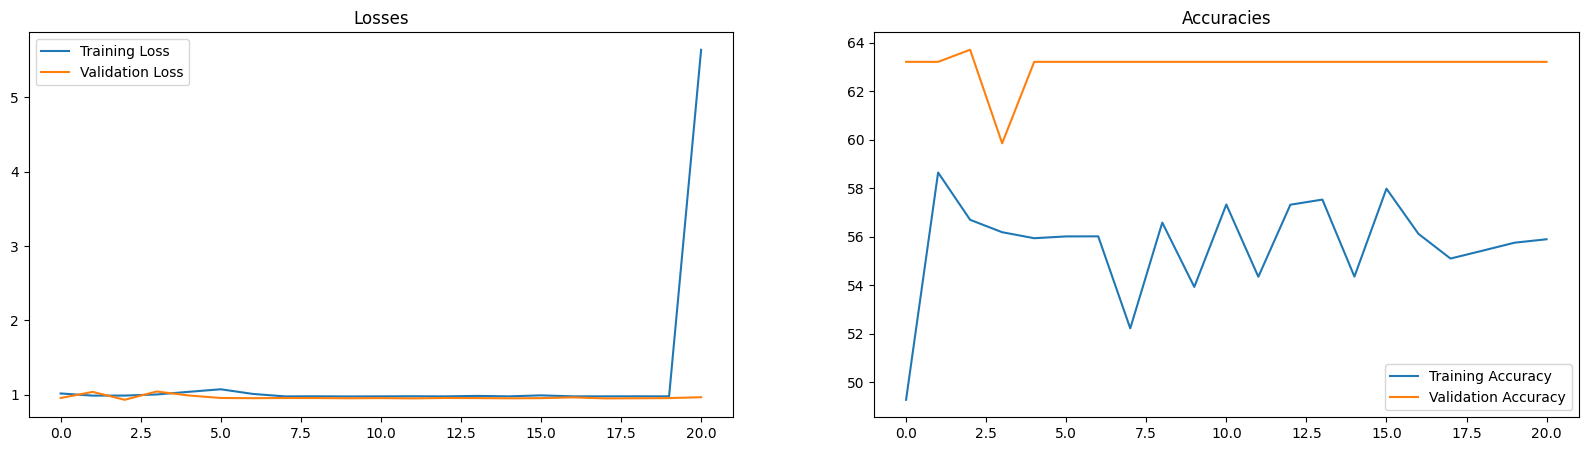

In [33]:
plot_loss_curves(history=history)

Index no.: 28 , Label: benign , Predicted: benign


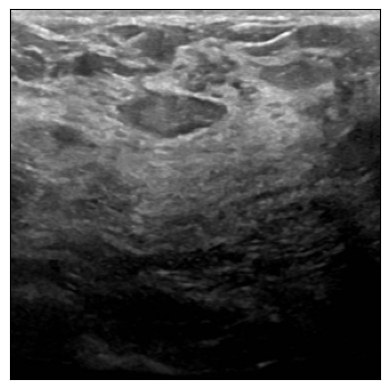

In [34]:
predict_image_from_test(model_1)

In [35]:
train_transforms = T.Compose(
    [
        T.Resize([324,324]),
        T.RandomHorizontalFlip(),
        T.RandomVerticalFlip(),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ],
)

val_transforms = T.Compose(
    [
        T.Resize([324,324]),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        
    ],
)

In [36]:
train_ds_2 = Dataset(images=train_data,labels=train_labels,transform=train_transforms)
val_ds_2 = Dataset(images=val_data,labels=val_labels,transform=val_transforms)
test_ds_2 = Dataset(images=test_data,labels=test_labels,transform=val_transforms)

In [37]:
train_loader_2 = DataLoader(train_ds_2, batch_size=BATCH_SIZE, num_workers=0, pin_memory=True, shuffle=True)   
val_loader_2 = DataLoader(val_ds_2, batch_size=BATCH_SIZE, num_workers=0, pin_memory=True, shuffle=True)
test_loader_2 = DataLoader(test_ds_2, batch_size=BATCH_SIZE, num_workers=0, pin_memory=True, shuffle=True) 

In [38]:
train_dl_2 = DeviceDataLoader(train_loader_2, device)
valid_dl_2 = DeviceDataLoader(val_loader_2, device)

In [39]:
model_2 = TestModel()
to_device(model_2, device)

TestModel(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 24, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=149784, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=3, bias=True)
)

In [41]:


history = [evaluate(model_2, valid_dl_2)]
history



[{'val_loss': 1.067710041999817, 'val_acc': 61.564430849074384}]

In [42]:


history += fit_one_cycle(model_2, train_dl_2, valid_dl_2, epochs=epochs, max_lr=L_rate, weight_decay=weight_decay, grad_clip=None, opt_func=opti)



  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[0]::: Last LR: 0.00050, Training Acc.: 47.332 %, Training Loss: 1.07584
:::::::::::::: Current Validation Acc.: 69.266 %
:::::::::::::: Current Validation Loss: 0.98512
Model is improving...


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[1]::: Last LR: 0.00081, Training Acc.: 56.822 %, Training Loss: 0.97553
:::::::::::::: Current Validation Acc.: 63.368 %
:::::::::::::: Current Validation Loss: 0.98501
Model is improving...


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[2]::: Last LR: 0.00132, Training Acc.: 52.274 %, Training Loss: 0.97822
:::::::::::::: Current Validation Acc.: 67.070 %
:::::::::::::: Current Validation Loss: 1.07664
Patience triggered: 1


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[3]::: Last LR: 0.00199, Training Acc.: 54.762 %, Training Loss: 1.00231
:::::::::::::: Current Validation Acc.: 76.004 %
:::::::::::::: Current Validation Loss: 0.98035
Model is improving...


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[4]::: Last LR: 0.00280, Training Acc.: 53.419 %, Training Loss: 1.01670
:::::::::::::: Current Validation Acc.: 67.824 %
:::::::::::::: Current Validation Loss: 0.91769
Model is improving...


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[5]::: Last LR: 0.00371, Training Acc.: 53.584 %, Training Loss: 1.00095
:::::::::::::: Current Validation Acc.: 73.747 %
:::::::::::::: Current Validation Loss: 0.96824
Patience triggered: 1


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[6]::: Last LR: 0.00470, Training Acc.: 56.157 %, Training Loss: 0.98558
:::::::::::::: Current Validation Acc.: 55.085 %
:::::::::::::: Current Validation Loss: 0.96647
Model is improving...


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[7]::: Last LR: 0.00570, Training Acc.: 58.726 %, Training Loss: 0.98179
:::::::::::::: Current Validation Acc.: 55.695 %
:::::::::::::: Current Validation Loss: 0.96434
Model is improving...


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[8]::: Last LR: 0.00668, Training Acc.: 52.396 %, Training Loss: 1.33793
:::::::::::::: Current Validation Acc.: 60.087 %
:::::::::::::: Current Validation Loss: 0.95885
Model is improving...


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[9]::: Last LR: 0.00760, Training Acc.: 58.046 %, Training Loss: 0.97822
:::::::::::::: Current Validation Acc.: 61.458 %
:::::::::::::: Current Validation Loss: 0.97967
Patience triggered: 1


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[10]::: Last LR: 0.00841, Training Acc.: 53.216 %, Training Loss: 0.98179
:::::::::::::: Current Validation Acc.: 61.861 %
:::::::::::::: Current Validation Loss: 0.95851
Model is improving...


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[11]::: Last LR: 0.00908, Training Acc.: 54.417 %, Training Loss: 0.97925
:::::::::::::: Current Validation Acc.: 54.202 %
:::::::::::::: Current Validation Loss: 0.95135
Model is improving...


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[12]::: Last LR: 0.00958, Training Acc.: 54.198 %, Training Loss: 0.97921
:::::::::::::: Current Validation Acc.: 55.191 %
:::::::::::::: Current Validation Loss: 0.95166
Patience triggered: 1


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[13]::: Last LR: 0.00990, Training Acc.: 58.677 %, Training Loss: 0.98079
:::::::::::::: Current Validation Acc.: 60.628 %
:::::::::::::: Current Validation Loss: 0.95764
Patience triggered: 2


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[14]::: Last LR: 0.01000, Training Acc.: 56.183 %, Training Loss: 157.43457
:::::::::::::: Current Validation Acc.: 58.293 %
:::::::::::::: Current Validation Loss: 1.09865
Patience triggered: 3
Early stopping activated!
Your model has finished training!
Your model has finished training!


In [43]:


test_acc_2 = eval_accuracy(test_loader_2, model_2)
print(f' Accuracy on test images: {test_acc_2}')



 Accuracy on test images: 55.55555725097656


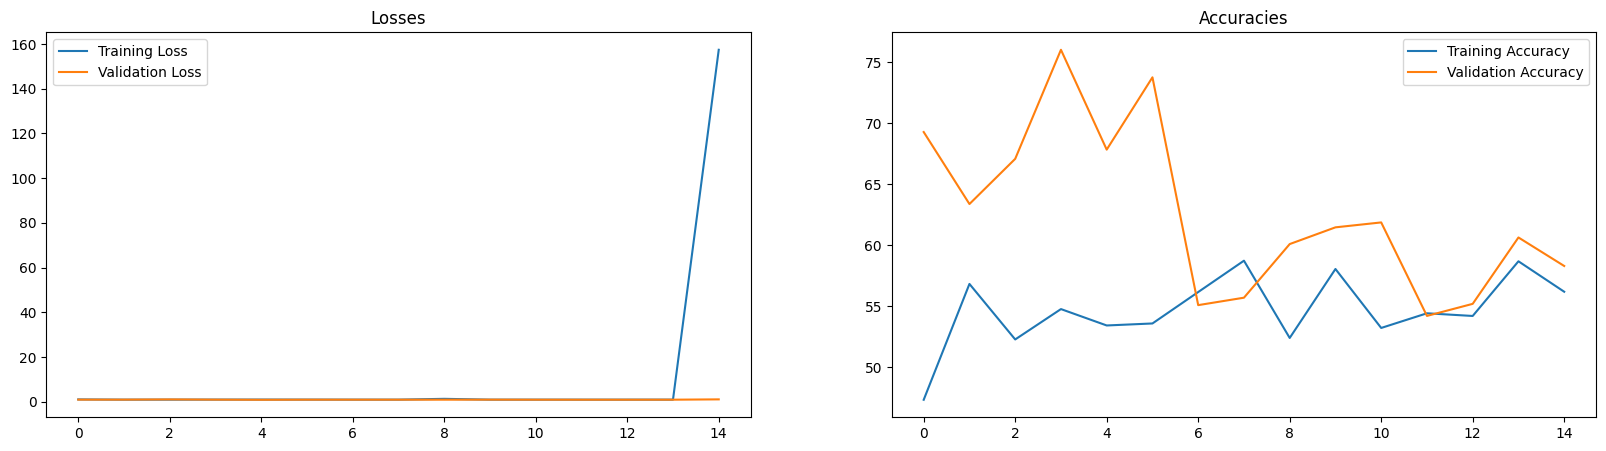

In [44]:
plot_loss_curves(history)

In [45]:
import gc

gc.collect()

torch.cuda.empty_cache()

In [46]:
class ResNet34Model(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.network = models.resnet34(pretrained=True)
        self.network.pool1 = nn.AvgPool2d(2)
        self.network.fc = nn.Linear(self.network.fc.in_features, len(classes))

    def forward(self, x):
        return self.network(x)

In [47]:


model_3 = ResNet34Model()
to_device(model_3, device)



Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to C:\Users\dhruv/.cache\torch\hub\checkpoints\resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:09<00:00, 9.54MB/s]


ResNet34Model(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [48]:
history = [evaluate(model_3, valid_dl_2)]
history

[{'val_loss': 1.0714584589004517, 'val_acc': 31.831652248536944}]

In [53]:
history += fit_one_cycle(model_3, train_dl_2, valid_dl_2, epochs=epochs, max_lr=L_rate, weight_decay=weight_decay, grad_clip=None, opt_func=opti, patience=4)

  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[0]::: Last LR: 0.00050, Training Acc.: 51.166 %, Training Loss: 1.03415
:::::::::::::: Current Validation Acc.: 61.255 %
:::::::::::::: Current Validation Loss: 0.88502
Model is improving...


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[1]::: Last LR: 0.00081, Training Acc.: 56.909 %, Training Loss: 0.99830
:::::::::::::: Current Validation Acc.: 28.726 %
:::::::::::::: Current Validation Loss: 10.05637
Patience triggered: 1


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[2]::: Last LR: 0.00132, Training Acc.: 50.116 %, Training Loss: 1.04148
:::::::::::::: Current Validation Acc.: 55.461 %
:::::::::::::: Current Validation Loss: 0.98523
Model is improving...


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[3]::: Last LR: 0.00199, Training Acc.: 54.393 %, Training Loss: 1.06801
:::::::::::::: Current Validation Acc.: 65.179 %
:::::::::::::: Current Validation Loss: 0.97671
Model is improving...


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[4]::: Last LR: 0.00280, Training Acc.: 48.484 %, Training Loss: 1.03140
:::::::::::::: Current Validation Acc.: 49.115 %
:::::::::::::: Current Validation Loss: 0.95877
Model is improving...


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[5]::: Last LR: 0.00371, Training Acc.: 56.893 %, Training Loss: 1.02441
:::::::::::::: Current Validation Acc.: 45.910 %
:::::::::::::: Current Validation Loss: 1.26778
Patience triggered: 1


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[6]::: Last LR: 0.00470, Training Acc.: 54.853 %, Training Loss: 1.01262
:::::::::::::: Current Validation Acc.: 40.862 %
:::::::::::::: Current Validation Loss: 1.02994
Model is improving...


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[7]::: Last LR: 0.00570, Training Acc.: 51.316 %, Training Loss: 1.00168
:::::::::::::: Current Validation Acc.: 58.920 %
:::::::::::::: Current Validation Loss: 1.75756
Patience triggered: 1


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[8]::: Last LR: 0.00668, Training Acc.: 52.679 %, Training Loss: 0.99595
:::::::::::::: Current Validation Acc.: 62.766 %
:::::::::::::: Current Validation Loss: 1.06852
Model is improving...


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[9]::: Last LR: 0.00760, Training Acc.: 52.802 %, Training Loss: 0.99709
:::::::::::::: Current Validation Acc.: 66.383 %
:::::::::::::: Current Validation Loss: 1.04730
Model is improving...


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[10]::: Last LR: 0.00841, Training Acc.: 56.942 %, Training Loss: 0.98658
:::::::::::::: Current Validation Acc.: 45.692 %
:::::::::::::: Current Validation Loss: 1.01246
Model is improving...


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[11]::: Last LR: 0.00908, Training Acc.: 52.259 %, Training Loss: 0.99096
:::::::::::::: Current Validation Acc.: 26.306 %
:::::::::::::: Current Validation Loss: 4.15300
Patience triggered: 1


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[12]::: Last LR: 0.00958, Training Acc.: 57.422 %, Training Loss: 0.98633
:::::::::::::: Current Validation Acc.: 60.991 %
:::::::::::::: Current Validation Loss: 0.96557
Model is improving...


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[13]::: Last LR: 0.00990, Training Acc.: 57.932 %, Training Loss: 0.98529
:::::::::::::: Current Validation Acc.: 66.456 %
:::::::::::::: Current Validation Loss: 0.95548
Model is improving...


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[14]::: Last LR: 0.01000, Training Acc.: 54.295 %, Training Loss: 0.98377
:::::::::::::: Current Validation Acc.: 70.063 %
:::::::::::::: Current Validation Loss: 0.96378
Patience triggered: 1


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[15]::: Last LR: 0.00998, Training Acc.: 55.488 %, Training Loss: 0.97994
:::::::::::::: Current Validation Acc.: 54.326 %
:::::::::::::: Current Validation Loss: 3.70602
Patience triggered: 2


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[16]::: Last LR: 0.00992, Training Acc.: 57.921 %, Training Loss: 0.98313
:::::::::::::: Current Validation Acc.: 56.900 %
:::::::::::::: Current Validation Loss: 0.97578
Model is improving...


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[17]::: Last LR: 0.00982, Training Acc.: 55.071 %, Training Loss: 0.98070
:::::::::::::: Current Validation Acc.: 60.885 %
:::::::::::::: Current Validation Loss: 1.68280
Patience triggered: 1


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[18]::: Last LR: 0.00968, Training Acc.: 55.641 %, Training Loss: 0.98099
:::::::::::::: Current Validation Acc.: 66.053 %
:::::::::::::: Current Validation Loss: 66204.69531
Patience triggered: 2


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[19]::: Last LR: 0.00950, Training Acc.: 58.474 %, Training Loss: 0.97798
:::::::::::::: Current Validation Acc.: 59.366 %
:::::::::::::: Current Validation Loss: 0.96746
Model is improving...


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[20]::: Last LR: 0.00929, Training Acc.: 53.607 %, Training Loss: 0.98010
:::::::::::::: Current Validation Acc.: 48.404 %
:::::::::::::: Current Validation Loss: 0.95099
Model is improving...


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[21]::: Last LR: 0.00905, Training Acc.: 57.466 %, Training Loss: 0.97901
:::::::::::::: Current Validation Acc.: 56.317 %
:::::::::::::: Current Validation Loss: 0.96476
Patience triggered: 1


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[22]::: Last LR: 0.00877, Training Acc.: 53.627 %, Training Loss: 0.97899
:::::::::::::: Current Validation Acc.: 44.000 %
:::::::::::::: Current Validation Loss: 2.62380
Patience triggered: 2


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[23]::: Last LR: 0.00846, Training Acc.: 54.824 %, Training Loss: 0.97925
:::::::::::::: Current Validation Acc.: 51.326 %
:::::::::::::: Current Validation Loss: 0.96652
Model is improving...


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[24]::: Last LR: 0.00812, Training Acc.: 56.438 %, Training Loss: 0.97966
:::::::::::::: Current Validation Acc.: 58.681 %
:::::::::::::: Current Validation Loss: 0.95518
Model is improving...


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[25]::: Last LR: 0.00775, Training Acc.: 54.134 %, Training Loss: 0.97916
:::::::::::::: Current Validation Acc.: 53.206 %
:::::::::::::: Current Validation Loss: 0.95540
Patience triggered: 1


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[26]::: Last LR: 0.00737, Training Acc.: 53.704 %, Training Loss: 0.97774
:::::::::::::: Current Validation Acc.: 61.735 %
:::::::::::::: Current Validation Loss: 0.95256
Model is improving...


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[27]::: Last LR: 0.00697, Training Acc.: 57.957 %, Training Loss: 0.97814
:::::::::::::: Current Validation Acc.: 55.997 %
:::::::::::::: Current Validation Loss: 0.96521
Patience triggered: 1


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[28]::: Last LR: 0.00655, Training Acc.: 56.443 %, Training Loss: 0.97881
:::::::::::::: Current Validation Acc.: 65.903 %
:::::::::::::: Current Validation Loss: 0.96578
Patience triggered: 2


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[29]::: Last LR: 0.00611, Training Acc.: 57.683 %, Training Loss: 0.97762
:::::::::::::: Current Validation Acc.: 64.490 %
:::::::::::::: Current Validation Loss: 0.95939
Model is improving...


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[30]::: Last LR: 0.00567, Training Acc.: 54.655 %, Training Loss: 0.97921
:::::::::::::: Current Validation Acc.: 56.772 %
:::::::::::::: Current Validation Loss: 0.95324
Model is improving...


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[31]::: Last LR: 0.00522, Training Acc.: 61.523 %, Training Loss: 0.97728
:::::::::::::: Current Validation Acc.: 61.664 %
:::::::::::::: Current Validation Loss: 0.97679
Patience triggered: 1


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[32]::: Last LR: 0.00478, Training Acc.: 56.689 %, Training Loss: 0.97926
:::::::::::::: Current Validation Acc.: 62.522 %
:::::::::::::: Current Validation Loss: 0.95848
Model is improving...


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[33]::: Last LR: 0.00433, Training Acc.: 58.373 %, Training Loss: 0.97804
:::::::::::::: Current Validation Acc.: 62.270 %
:::::::::::::: Current Validation Loss: 0.95644
Model is improving...


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[34]::: Last LR: 0.00389, Training Acc.: 58.442 %, Training Loss: 0.97837
:::::::::::::: Current Validation Acc.: 61.079 %
:::::::::::::: Current Validation Loss: 0.95703
Patience triggered: 1


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[35]::: Last LR: 0.00345, Training Acc.: 57.135 %, Training Loss: 0.98045
:::::::::::::: Current Validation Acc.: 55.918 %
:::::::::::::: Current Validation Loss: 0.98274
Patience triggered: 2


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[36]::: Last LR: 0.00303, Training Acc.: 53.500 %, Training Loss: 0.97869
:::::::::::::: Current Validation Acc.: 66.221 %
:::::::::::::: Current Validation Loss: 0.96385
Model is improving...


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[37]::: Last LR: 0.00263, Training Acc.: 57.224 %, Training Loss: 0.97735
:::::::::::::: Current Validation Acc.: 56.658 %
:::::::::::::: Current Validation Loss: 0.97293
Patience triggered: 1


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[38]::: Last LR: 0.00225, Training Acc.: 57.707 %, Training Loss: 0.97680
:::::::::::::: Current Validation Acc.: 62.084 %
:::::::::::::: Current Validation Loss: 0.95537
Model is improving...


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[39]::: Last LR: 0.00188, Training Acc.: 58.358 %, Training Loss: 0.97757
:::::::::::::: Current Validation Acc.: 59.460 %
:::::::::::::: Current Validation Loss: 0.95582
Patience triggered: 1


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[40]::: Last LR: 0.00154, Training Acc.: 57.317 %, Training Loss: 0.97683
:::::::::::::: Current Validation Acc.: 46.127 %
:::::::::::::: Current Validation Loss: 0.95490
Model is improving...


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[41]::: Last LR: 0.00123, Training Acc.: 53.719 %, Training Loss: 0.97771
:::::::::::::: Current Validation Acc.: 60.336 %
:::::::::::::: Current Validation Loss: 0.95258
Model is improving...


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[42]::: Last LR: 0.00095, Training Acc.: 55.044 %, Training Loss: 0.97701
:::::::::::::: Current Validation Acc.: 61.706 %
:::::::::::::: Current Validation Loss: 0.96471
Patience triggered: 1


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[43]::: Last LR: 0.00071, Training Acc.: 58.580 %, Training Loss: 0.97654
:::::::::::::: Current Validation Acc.: 64.523 %
:::::::::::::: Current Validation Loss: 0.97310
Patience triggered: 2


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[44]::: Last LR: 0.00050, Training Acc.: 53.289 %, Training Loss: 0.97636
:::::::::::::: Current Validation Acc.: 61.267 %
:::::::::::::: Current Validation Loss: 0.97366
Patience triggered: 3


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[45]::: Last LR: 0.00032, Training Acc.: 54.904 %, Training Loss: 0.97624
:::::::::::::: Current Validation Acc.: 58.635 %
:::::::::::::: Current Validation Loss: 0.95484
Model is improving...


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[46]::: Last LR: 0.00018, Training Acc.: 52.753 %, Training Loss: 0.97621
:::::::::::::: Current Validation Acc.: 56.717 %
:::::::::::::: Current Validation Loss: 0.95521
Patience triggered: 1


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[47]::: Last LR: 0.00008, Training Acc.: 56.509 %, Training Loss: 0.97610
:::::::::::::: Current Validation Acc.: 63.690 %
:::::::::::::: Current Validation Loss: 0.95498
Model is improving...


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[48]::: Last LR: 0.00002, Training Acc.: 54.655 %, Training Loss: 0.97605
:::::::::::::: Current Validation Acc.: 56.965 %
:::::::::::::: Current Validation Loss: 0.95500
Patience triggered: 1


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[49]::: Last LR: 0.00000, Training Acc.: 53.495 %, Training Loss: 0.97603
:::::::::::::: Current Validation Acc.: 58.203 %
:::::::::::::: Current Validation Loss: 0.97332
Patience triggered: 2
Your model has finished training!


In [54]:
# save the model 
torch.save(model_3.state_dict(), 'resnet34_model.pth')

In [55]:
test_acc_3 = eval_accuracy(test_loader_2, model_3)
print(f' Accuracy on test images: {test_acc_3}')

 Accuracy on test images: 55.55555725097656


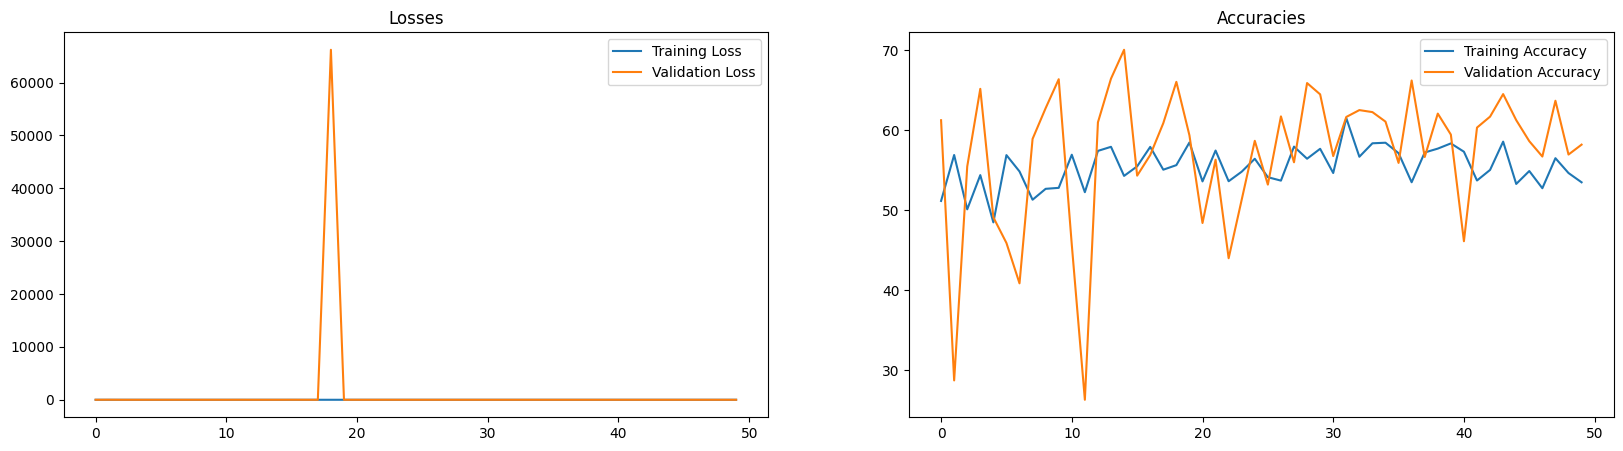

In [56]:
plot_loss_curves(history)

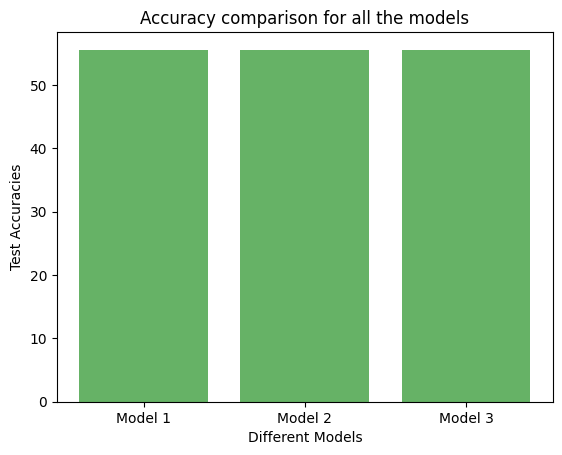

In [57]:


test_accs = [test_acc_1.cpu(), test_acc_2.cpu(), test_acc_3.cpu()]
test_accs = pd.DataFrame(test_accs, columns=["test_accs"])
test_accs["models"] = ["Model 1", "Model 2", "Model 3"]
plt.bar(test_accs["models"], test_accs["test_accs"], facecolor='g', alpha=0.60)
plt.xlabel('Different Models')
plt.ylabel('Test Accuracies')
plt.title('Accuracy comparison for all the models')
plt.show()



In [58]:
def saliency(model, test_ds, index):
    """
    Draws a saliency map for a given index image to explain the model's decision making process.
    """
    for param in model.parameters():
        param.requires_grad = False
    
    model.eval()
    image, label = test_ds[index]
    img = image.unsqueeze(0)
    img = img.cuda()
    img.requires_grad = True
    
    preds = model(img)
    score, indices = torch.max(preds, 1)
    score.backward()
    
    s, _ = torch.max(torch.abs(img.grad[0]), dim=0)
    s = (s-s.min())/(s.max()-s.min())

    #plot image and its saliency map
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(image.cpu().detach().numpy().transpose(1, 2, 0))
    print("Class: ", classes[label])
    print("Prediction: ", classes[indices])
    ax[0].set_title('Original')
    ax[0].axis('off')
    ax[1].imshow(s.cpu().numpy(), cmap='plasma') #set any of the cmap from here: https://matplotlib.org/stable/tutorials/colors/colormaps.html
    ax[1].set_title('Saliency Map')
    ax[1].axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Class:  benign
Prediction:  benign


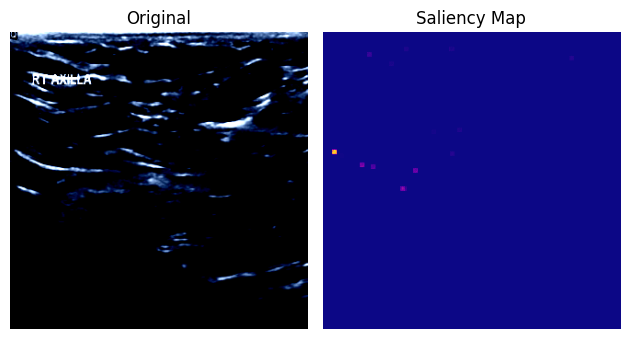

In [64]:
saliency(model_2, test_ds_2, index=6)

In [66]:
torch.save(model_1.state_dict(), 'model_1.pth')
torch.save(model_2.state_dict(), 'model_2.pth')
torch.save(model_3.state_dict(), 'model_3.pth')


In [71]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

def gradcam(model, test_ds, index):
    """
    Draws a Grad-CAM map for a given index image to explain the model's decision-making process.
    """
    # Set model to evaluation mode
    model.eval()

    # Fetch the image and label from the dataset
    image, label = test_ds[index]
    img = image.unsqueeze(0).cuda()  # Add batch dimension and move to GPU
    img.requires_grad = True

    # Forward pass
    preds = model(img)
    score, indices = torch.max(preds, 1)

    # Zero existing gradients and register hook to capture gradients of layer4
    model.zero_grad()
    gradients = []
    def hook_fn(module, grad_in, grad_out):
        gradients.append(grad_out[0])

    # Register hook on layer4, the last convolutional block of ResNet-34
    handle = model.network.layer4.register_backward_hook(hook_fn)

    # Backward pass
    score.backward()

    # Get the gradients of layer4
    grad = gradients[0]
    pooled_gradients = torch.mean(grad, dim=[0, 2, 3])

    # Get activations of layer4
    activations = model.network.layer4(img).detach()

    # Weight the channels by corresponding pooled gradients
    for i in range(activations.shape[1]):
        activations[:, i, :, :] *= pooled_gradients[i]

    # Create heatmap
    heatmap = torch.mean(activations, dim=1).squeeze()
    heatmap = F.relu(heatmap)
    heatmap /= torch.max(heatmap)

    # Plot image and its Grad-CAM map
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(image.cpu().numpy().transpose(1, 2, 0))
    ax[0].set_title(f'Original (Class: {classes[label]}, Prediction: {classes[indices]})')
    ax[0].axis('off')

    ax[1].imshow(heatmap.cpu().numpy(), cmap='plasma')
    ax[1].set_title('Grad-CAM Map')
    ax[1].axis('off')

    plt.tight_layout()
    plt.show()

    # Remove the hook after use
    handle.remove()

# Run the function
gradcam(model_3, test_ds_2, index=6)


IndexError: list index out of range